# Benchmarking lung integration

Here we walkthrough applying the integration benchmarking metrics on the lung atlas example from the [scIB paper](https://www.nature.com/articles/s41592-021-01336-8).

In [15]:
import numpy as np
from anndata import AnnData
import scanpy as sc
import matplotlib.pyplot as plt

from scib_metrics.benchmark import Benchmarker
%matplotlib inline

## Load and preprocess data

In [2]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)


/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preproces

We subset to the highly variable genes so that each method has the same input.

In [5]:
adata = adata[:, adata.var.highly_variable].copy()

In [6]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

## Run methods

Here we run a few embedding-based methods. By focusing on embedding-based methods, we can substantially reduce the runtime of the benchmarking metrics.

In principle, graph-based integration methods can also be benchmarked on some of the metrics that have graph inputs. Future work can explore using graph convolutional networks to embed the graph and then using the embedding-based metrics.

### Scanorama

In [7]:
%%capture
import scanorama
# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

### Liger

In [8]:
import pyliger
bdata = adata.copy()
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns['var_gene_idx'] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
100%|██████████| 30/30 [03:04<00:00,  6.14s/it]


### Harmony

In [9]:
from harmony import harmonize
Z = harmonize(adata.obsm["X_pca"], adata.obs, batch_key = "batch")
adata.obsm["Harmony"] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


### scVI

In [10]:
%%capture
import scvi
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=246` reached.


### scANVI

In [18]:
%%capture
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata.obsm["scANVI"] = lvae.get_latent_representation()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Perform the benchmark

In [19]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", "scANVI"],
    n_jobs=6,
)
bm.benchmark()


Embeddings: 100%|██████████| 6/6 [01:46<00:00, 17.83s/it]


In [20]:
bm.get_results(min_max_scale=False).transpose()

Embedding,Unintegrated,Scanorama,LIGER,Harmony,scVI,scANVI,Metric Type
Isolated labels,0.464394,0.504315,0.470465,0.46885,0.526255,0.529238,Bio conservation
Leiden NMI,0.735036,0.734221,0.634112,0.668982,0.75048,0.760137,Bio conservation
Leiden ARI,0.426221,0.499289,0.436241,0.505879,0.587844,0.621599,Bio conservation
Silhouette label,0.585415,0.564586,0.548402,0.56432,0.543061,0.598603,Bio conservation
cLISI,1.0,0.999625,0.986097,0.994074,0.994309,0.998383,Bio conservation
Silhouette batch,0.855258,0.932109,0.861545,0.878664,0.897465,0.885807,Batch correction
iLISI,0.007811,0.064213,0.164163,0.128523,0.119579,0.107479,Batch correction
KBET,0.248808,0.316881,0.485941,0.472178,0.371274,0.380133,Batch correction
Graph connectivity,0.764953,0.675395,0.678446,0.765538,0.899629,0.911423,Batch correction
PCR comparison,0,0.21128,0.785972,0.522324,0.879229,0.783005,Batch correction


### Visualize the results

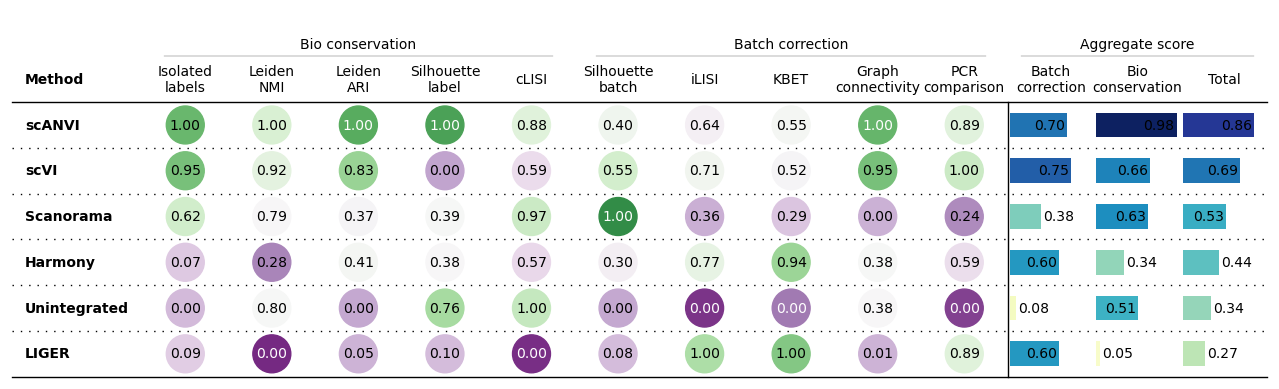

In [21]:
bm.plot_results_table()

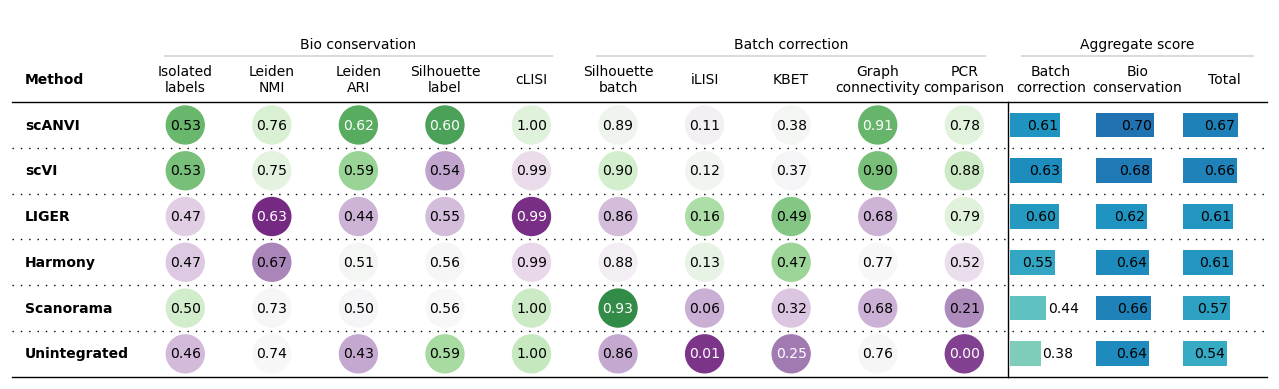

In [22]:
bm.plot_results_table(min_max_scale=False)